In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import torch
from lsh import LSH
import sklearn
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from utils.torchinterp import Interp1d

In [3]:
df_train = pd.read_csv("../dataset/pointcloud_mnist_2d/train.csv")
df_test = pd.read_csv("../dataset/pointcloud_mnist_2d/test.csv")

X = df_train[df_train.columns[1:]].to_numpy()
y = df_train[df_train.columns[0]].to_numpy()

X = X.reshape(X.shape[0], -1, 3)

X.shape, y.shape

((60000, 351, 3), (60000,))

In [4]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [5]:
def preprocess_samples(X):
    samples = []
    for i in range(X.shape[0]):
        sample = X[i, :, :]
        sample = sample[sample[:, 2] > 0][:, :2]
        samples.append(sample)
    
    return samples

In [6]:
samples = preprocess_samples(X)

In [7]:
X_test = df_test[df_test.columns[1:]].to_numpy()
y_test = df_test[df_test.columns[0]].to_numpy()
X_test = torch.from_numpy(X_test.reshape(X_test.shape[0], -1, 3))

In [8]:
test_samples = preprocess_samples(X_test)

In [9]:
from itertools import combinations
from tqdm.notebook import tqdm

In [10]:
def compute_gem(samples, power):
    gems = []
    for sample in samples:
        p_avg = torch.cat([torch.pow(torch.pow(sample.to(torch.float), p).mean(0), 1/p) for p in range(1, power + 1)])
        gems.append(p_avg)
    return torch.stack(gems, dim=0)

In [11]:
p=1
X_j = compute_gem(samples, p)

In [12]:
X_j.shape

torch.Size([60000, 2])

In [13]:
X_test_j = compute_gem(test_samples, p)

In [14]:
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_j , y.numpy())

KNeighborsClassifier(n_neighbors=9)

In [15]:
preds = neigh.predict(X_test_j)
accuracy_score(preds, y_test)

0.1189

  0%|          | 0/25 [00:00<?, ?it/s]

0.1189
0.4007
0.5101
0.5603
0.5887
0.6044
0.6235
0.6335
0.644
0.6554
0.6619
0.6679
0.6717
0.6805
0.6818
0.6855
0.6897
0.6943
0.694
0.6941
0.6965
0.6961
0.6966
0.6967
0.6973


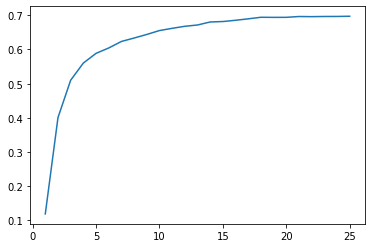

In [17]:
ps = [i for i in range(1, 26)]
p_accs = []
for i in tqdm(ps):
    X_j = compute_gem(samples, i)
    X_test_j = compute_gem(test_samples, i)
    
    neigh = KNeighborsClassifier(n_neighbors=9)
    neigh.fit(X_j , y.numpy())
    
    preds = neigh.predict(X_test_j)
    acc = accuracy_score(preds, y_test)
    print(acc)
    p_accs.append(acc)

plt.plot(ps, p_accs)
plt.show()

In [18]:
accs = []
num_neighs = 10
for i in tqdm(range(1, num_neighs)):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_j, y.numpy())
    preds = neigh.predict(X_test_j)
    accs.append(accuracy_score(preds, y_test))

  0%|          | 0/9 [00:00<?, ?it/s]

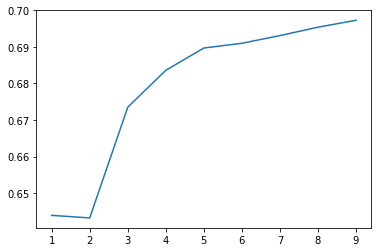

In [19]:
plt.plot(range(1, num_neighs), accs)
plt.show()

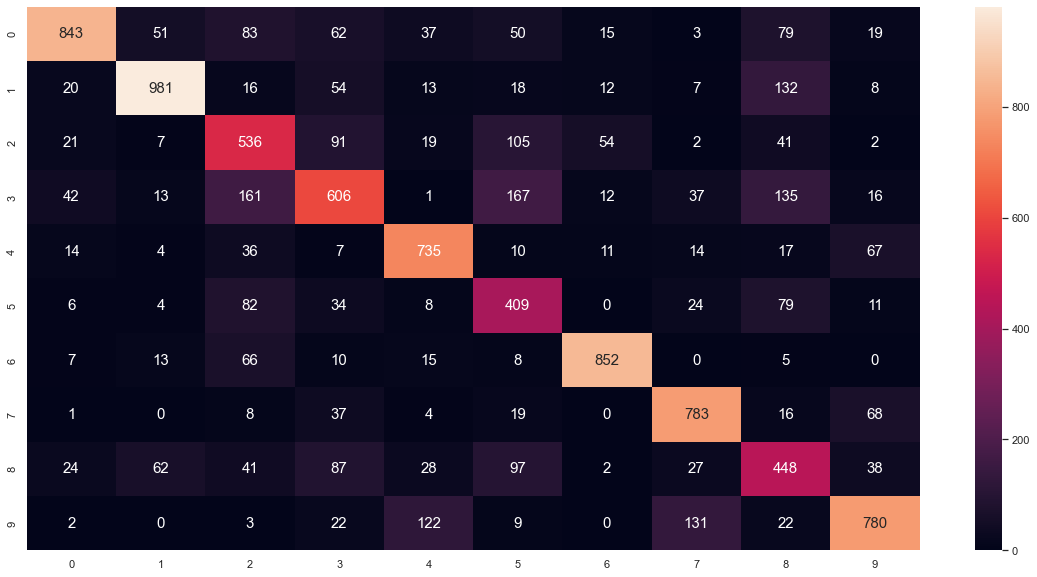

In [20]:
import seaborn as sn
cm = confusion_matrix(preds, y_test)

df_cm = pd.DataFrame(cm, range(10), range(10))
plt.figure(figsize=(20,10))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g')

plt.show()